# Projeto de Previsão da Inflação (IPCA) no Brasil - Modelo Avançado

Este notebook representa a terceira etapa do projeto de previsão da variação mensal do IPCA. Nesta versão "avançada", o objetivo é explorar um modelo de machine learning mais robusto, o Random Forest Regressor, e utilizar uma técnica de validação cruzada apropriada para séries temporais (TimeSeriesSplit) para avaliar seu desempenho.

As features iniciais serão as mesmas utilizadas no modelo intermediário: lags do IPCA, da Taxa Selic e da Taxa de Câmbio, com dados a partir de janeiro de 2000.

**Objetivos Específicos desta Versão:**
* Coletar e preparar os dados históricos do IPCA, Selic e Câmbio (desde 2000).
* Criar features baseadas em lags para todas as variáveis.
* Implementar a validação cruzada para séries temporais (`TimeSeriesSplit`).
* Treinar e avaliar um modelo Random Forest Regressor.
* Comparar o desempenho com os modelos linear básico e linear intermediário.
* Analisar a importância das features fornecida pelo Random Forest.

In [20]:
pip install python-bcb

In [21]:
import pandas as pd
import numpy as np
from bcb import sgs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações visuais (opcional)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Coleta e Preparação dos Dados (a partir de 2000)
Coletaremos as séries do IPCA, Selic (Série 11 - diária efetiva) e Câmbio (Série 1 - PTAX venda) desde janeiro de 2000. As séries diárias serão agregadas para frequência mensal.

In [22]:
#Coleta do IPCA (Série 433)
ipca_dados = sgs.get({'IPCA': 433}, start='2000-01-01')
ipca_dados.index = pd.to_datetime(ipca_dados.index)
ipca_dados.index = ipca_dados.index + pd.offsets.MonthEnd(0) # Ajusta para fim do mês
print("--- IPCA Dados (a partir de 2000) ---")
ipca_dados.info()
print(ipca_dados.head())

--- IPCA Dados (a partir de 2000) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-31 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPCA    304 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
            IPCA
Date            
2000-01-31  0.62
2000-02-29  0.13
2000-03-31  0.22
2000-04-30  0.42
2000-05-31  0.01


In [23]:
#Coleta e Processamento da Selic (Série 11 - Diária Efetiva)
print("\n--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2000 ---")
selic_mensal = pd.DataFrame()
try:
    start_date_2000 = pd.to_datetime('2000-01-01')
    end_date_2009 = pd.to_datetime('2009-12-31')
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    selic_diaria_p1 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2000.strftime('%Y-%m-%d'), end=end_date_2009.strftime('%Y-%m-%d'))
    selic_diaria_p2 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    selic_diaria_p3 = sgs.get({'SELIC_DIARIA_AD': 11}, start=start_date_2020.strftime('%Y-%m-%d'))

    selic_diaria_raw = pd.concat([selic_diaria_p1, selic_diaria_p2, selic_diaria_p3])
    selic_diaria_raw = selic_diaria_raw[~selic_diaria_raw.index.duplicated(keep='first')]
    selic_diaria_raw.index = pd.to_datetime(selic_diaria_raw.index)

    selic_mensal_temp = selic_diaria_raw.resample('ME').mean()
    selic_mensal_temp.rename(columns={'SELIC_DIARIA_AD': 'SELIC_DIARIA_AVG_MENSAL'}, inplace=True)
    selic_mensal = selic_mensal_temp
    print("\nSelic Diária Média Mensal (% a.d.):")
    selic_mensal.info()
    print(selic_mensal.head())
except Exception as e:
    print(f"Erro ao buscar ou processar Selic Diária Efetiva (11): {e}")
    selic_mensal = pd.DataFrame() # Garante que é um DataFrame vazio em caso de erro


--- Buscando Taxa Selic Diária Efetiva (código 11) a partir de 2000 ---

Selic Diária Média Mensal (% a.d.):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2000-01-31 to 2025-05-31
Freq: ME
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SELIC_DIARIA_AVG_MENSAL  305 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
            SELIC_DIARIA_AVG_MENSAL
Date                               
2000-01-31                 0.068845
2000-02-29                 0.068617
2000-03-31                 0.068541
2000-04-30                 0.067777
2000-05-31                 0.067423


In [24]:
#Coleta e Processamento do Câmbio (Série 1 - Dólar PTAX Venda)
print("\n--- Buscando Taxa de Câmbio (código 1) a partir de 2000 ---")
cambio_mensal = pd.DataFrame()
try:
    start_date_2000 = pd.to_datetime('2000-01-01')
    end_date_2009 = pd.to_datetime('2009-12-31')
    start_date_2010 = pd.to_datetime('2010-01-01')
    end_date_2019 = pd.to_datetime('2019-12-31')
    start_date_2020 = pd.to_datetime('2020-01-01')

    cambio_diario_p1 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2000.strftime('%Y-%m-%d'), end=end_date_2009.strftime('%Y-%m-%d'))
    cambio_diario_p2 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2010.strftime('%Y-%m-%d'), end=end_date_2019.strftime('%Y-%m-%d'))
    cambio_diario_p3 = sgs.get({'CAMBIO_USD_VENDA': 1}, start=start_date_2020.strftime('%Y-%m-%d'))

    cambio_diario_raw = pd.concat([cambio_diario_p1, cambio_diario_p2, cambio_diario_p3])
    cambio_diario_raw = cambio_diario_raw[~cambio_diario_raw.index.duplicated(keep='first')]
    cambio_diario_raw.index = pd.to_datetime(cambio_diario_raw.index)

    cambio_mensal_temp = cambio_diario_raw.resample('ME').mean()
    cambio_mensal_temp.rename(columns={'CAMBIO_USD_VENDA': 'CAMBIO_USD_AVG'}, inplace=True)
    cambio_mensal = cambio_mensal_temp
    print("\nCâmbio Médio Mensal:")
    cambio_mensal.info()
    print(cambio_mensal.head())
except Exception as e:
    print(f"Erro ao buscar ou processar Taxa de Câmbio (1): {e}")
    cambio_mensal = pd.DataFrame() # Garante que é um DataFrame vazio em caso de erro


--- Buscando Taxa de Câmbio (código 1) a partir de 2000 ---

Câmbio Médio Mensal:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306 entries, 2000-01-31 to 2025-06-30
Freq: ME
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CAMBIO_USD_AVG  306 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
            CAMBIO_USD_AVG
Date                      
2000-01-31        1.803724
2000-02-29        1.775290
2000-03-31        1.742033
2000-04-30        1.768168
2000-05-31        1.827932


In [25]:
#Junção e Criação de Lags
# Verificando se os DataFrames foram carregados corretamente antes de juntar
if ipca_dados.empty or selic_mensal.empty or cambio_mensal.empty:
    print("ERRO: Um ou mais DataFrames de dados brutos estão vazios. Verifique as etapas de coleta.")
else:
    df_avancado = pd.merge(ipca_dados, selic_mensal, left_index=True, right_index=True, how='inner')
    df_avancado = pd.merge(df_avancado, cambio_mensal, left_index=True, right_index=True, how='inner')

    print("\n--- DataFrame Combinado (df_avancado) antes dos lags ---")
    print(df_avancado.head())
    df_avancado.info()

    # Lags do IPCA
    df_avancado['IPCA_lag1'] = df_avancado['IPCA'].shift(1)
    df_avancado['IPCA_lag2'] = df_avancado['IPCA'].shift(2)
    df_avancado['IPCA_lag3'] = df_avancado['IPCA'].shift(3)

    # Lags da Selic
    df_avancado['SELIC_lag1'] = df_avancado['SELIC_DIARIA_AVG_MENSAL'].shift(1)
    df_avancado['SELIC_lag2'] = df_avancado['SELIC_DIARIA_AVG_MENSAL'].shift(2)

    # Lags do Câmbio
    df_avancado['CAMBIO_lag1'] = df_avancado['CAMBIO_USD_AVG'].shift(1)
    df_avancado['CAMBIO_lag2'] = df_avancado['CAMBIO_USD_AVG'].shift(2)

    # Removendo NaNs
    df_avancado.dropna(inplace=True)

    print("\n--- DataFrame df_avancado após lags e dropna (primeiras linhas) ---")
    print(df_avancado.head())
    df_avancado.info()


--- DataFrame Combinado (df_avancado) antes dos lags ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2000-01-31  0.62                 0.068845        1.803724
2000-02-29  0.13                 0.068617        1.775290
2000-03-31  0.22                 0.068541        1.742033
2000-04-30  0.42                 0.067777        1.768168
2000-05-31  0.01                 0.067423        1.827932
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   IPCA                     304 non-null    float64
 1   SELIC_DIARIA_AVG_MENSAL  304 non-null    float64
 2   CAMBIO_USD_AVG           304 non-null    float64
dtypes: float64(3)
memory usage: 9.5 KB

--- DataFrame df_avancado após lags e dropna (primeiras linhas) ---
            IPCA  SELIC_DIARIA_AVG

### Junção dos DataFrames e Engenharia de Features
Unimos as séries em um DataFrame principal e criamos as features de lag.

### Definindo Features (X_avancado) e Variável Alvo (y_avancado)

In [26]:
#Definindo X e y
if 'df_avancado' in locals() and not df_avancado.empty:
    features_avancadas = [
        'IPCA_lag1', 'IPCA_lag2', 'IPCA_lag3',
        'SELIC_lag1', 'SELIC_lag2',
        'CAMBIO_lag1', 'CAMBIO_lag2'
    ]
    X_avancado = df_avancado[features_avancadas]
    y_avancado = df_avancado['IPCA']

    print("\n--- Features X_avancado (primeiras linhas) ---")
    print(X_avancado.head())
    print("\n--- Alvo y_avancado (primeiras linhas) ---")
    print(y_avancado.head())
    print("\nDimensões de X_avancado:", X_avancado.shape)
    print("Dimensões de y_avancado:", y_avancado.shape)
else:
    print("ERRO: df_avancado não foi criado ou está vazio. Verifique as etapas anteriores.")


--- Features X_avancado (primeiras linhas) ---
            IPCA_lag1  IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  \
Date                                                                  
2000-04-30       0.22       0.13       0.62    0.068541    0.068617   
2000-05-31       0.42       0.22       0.13    0.067777    0.068541   
2000-06-30       0.01       0.42       0.22    0.067423    0.067777   
2000-07-31       0.23       0.01       0.42    0.065838    0.067423   
2000-08-31       1.61       0.23       0.01    0.061807    0.065838   

            CAMBIO_lag1  CAMBIO_lag2  
Date                                  
2000-04-30     1.742033     1.775290  
2000-05-31     1.768168     1.742033  
2000-06-30     1.827932     1.768168  
2000-07-31     1.808329     1.827932  
2000-08-31     1.797824     1.808329  

--- Alvo y_avancado (primeiras linhas) ---
Date
2000-04-30    0.42
2000-05-31    0.01
2000-06-30    0.23
2000-07-31    1.61
2000-08-31    1.31
Name: IPCA, dtype: float64

Dimensões

##Validação Cruzada e Modelagem com Random Forest Regressor

Vvamos aplicar uma técnica de validação cruzada apropriada para séries temporais, o `TimeSeriesSplit`, e treinar um modelo `RandomForestRegressor`.

### Validação Cruzada para Séries Temporais (`TimeSeriesSplit`)
Para dados de séries temporais, a validação cruzada k-fold tradicional não é adequada, pois ela embaralha os dados, desconsiderando a ordem temporal. O `TimeSeriesSplit` resolve isso criando "folds" (divisões) onde o conjunto de treino sempre precede o conjunto de teste. Por exemplo, com 3 folds:
1.  Treino: Mês 1 a N; Teste: Mês N+1 a N+k
2.  Treino: Mês 1 a N+k; Teste: Mês N+k+1 a N+2k
3.  E assim por diante.

Isso nos dá uma avaliação mais robusta do desempenho do modelo em dados "futuros" que ele não viu.

In [27]:
# Verificar se X_avancado e y_avancado existem e não estão vazios
if 'X_avancado' in locals() and 'y_avancado' in locals() and not X_avancado.empty and not y_avancado.empty:
    # Configura o TimeSeriesSplit
    # n_splits define o número de divisões (folds). 5 é um valor comum.
    # test_size pode ser usado para definir o tamanho do conjunto de teste em cada split (ex: 12 meses)
    # Se test_size não for definido, o último fold terá 1/ (n_splits+1) dos dados, e assim por diante.
    # Para nosso caso, com 24 meses de teste no modelo anterior, podemos usar test_size=24 se quisermos
    # manter um tamanho de teste fixo, ou deixar o padrão.
    # Vamos começar com n_splits=5 e deixar o test_size como padrão para ver como se comporta.
    # O importante é que o TimeSeriesSplit garante que os dados de treino vêm antes dos de teste.

    tscv = TimeSeriesSplit(n_splits=5) # Usaremos 5 folds

    # Instancia o RandomForestRegressor
    # n_estimators: número de árvores na floresta.
    # random_state: para reprodutibilidade.
    # n_jobs=-1: para usar todos os processadores disponíveis (acelera o treinamento).
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=False) # oob_score=False é o padrão

    # Listas para armazenar os erros de cada fold
    mae_scores_rf = []
    rmse_scores_rf = []

    print("Iniciando validação cruzada com TimeSeriesSplit e RandomForestRegressor...")
    # Loop através dos folds do TimeSeriesSplit
    for fold_num, (train_index, test_index) in enumerate(tscv.split(X_avancado)):
        print(f"\n--- Fold {fold_num + 1} ---")
        X_train_fold, X_test_fold = X_avancado.iloc[train_index], X_avancado.iloc[test_index]
        y_train_fold, y_test_fold = y_avancado.iloc[train_index], y_avancado.iloc[test_index]

        print(f"Tamanho do Treino: {len(X_train_fold)} amostras (de {X_train_fold.index.min().strftime('%Y-%m-%d')} a {X_train_fold.index.max().strftime('%Y-%m-%d')})")
        print(f"Tamanho do Teste: {len(X_test_fold)} amostras (de {X_test_fold.index.min().strftime('%Y-%m-%d')} a {X_test_fold.index.max().strftime('%Y-%m-%d')})")

        # Treina o modelo no fold de treino atual
        rf_model.fit(X_train_fold, y_train_fold)

        # Faz previsões no fold de teste atual
        predictions_fold_rf = rf_model.predict(X_test_fold)

        # Calcula as métricas para o fold atual
        mae_fold = mean_absolute_error(y_test_fold, predictions_fold_rf)
        mse_fold = mean_squared_error(y_test_fold, predictions_fold_rf)
        rmse_fold = np.sqrt(mse_fold)

        mae_scores_rf.append(mae_fold)
        rmse_scores_rf.append(rmse_fold)

        print(f"MAE no Fold {fold_num + 1}: {mae_fold:.4f}")
        print(f"RMSE no Fold {fold_num + 1}: {rmse_fold:.4f}")

    # Métricas médias da validação cruzada
    print("\n--- Resultados Médios da Validação Cruzada (Random Forest) ---")
    print(f"MAE Médio: {np.mean(mae_scores_rf):.4f} (Desvio Padrão: {np.std(mae_scores_rf):.4f})")
    print(f"RMSE Médio: {np.mean(rmse_scores_rf):.4f} (Desvio Padrão: {np.std(rmse_scores_rf):.4f})")

else:
    print("ERRO: X_avancado ou y_avancado não foram criados ou estão vazios. Verifique as etapas de preparação de dados.")

Iniciando validação cruzada com TimeSeriesSplit e RandomForestRegressor...

--- Fold 1 ---
Tamanho do Treino: 51 amostras (de 2000-04-30 a 2004-06-30)
Tamanho do Teste: 50 amostras (de 2004-07-31 a 2008-08-31)
MAE no Fold 1: 0.2257
RMSE no Fold 1: 0.2928

--- Fold 2 ---
Tamanho do Treino: 101 amostras (de 2000-04-30 a 2008-08-31)
Tamanho do Teste: 50 amostras (de 2008-09-30 a 2012-10-31)
MAE no Fold 2: 0.1676
RMSE no Fold 2: 0.2074

--- Fold 3 ---
Tamanho do Treino: 151 amostras (de 2000-04-30 a 2012-10-31)
Tamanho do Teste: 50 amostras (de 2012-11-30 a 2016-12-31)
MAE no Fold 3: 0.4218
RMSE no Fold 3: 0.5674

--- Fold 4 ---
Tamanho do Treino: 201 amostras (de 2000-04-30 a 2016-12-31)
Tamanho do Teste: 50 amostras (de 2017-01-31 a 2021-02-28)
MAE no Fold 4: 0.3056
RMSE no Fold 4: 0.4060

--- Fold 5 ---
Tamanho do Treino: 251 amostras (de 2000-04-30 a 2021-02-28)
Tamanho do Teste: 50 amostras (de 2021-03-31 a 2025-04-30)
MAE no Fold 5: 0.3469
RMSE no Fold 5: 0.4454

--- Resultados Médio

### Análise dos Resultados da Validação Cruzada (Random Forest)

A validação cruzada com `TimeSeriesSplit` (5 folds) foi aplicada ao modelo `RandomForestRegressor`. Esta técnica treina e testa o modelo em diferentes janelas de tempo, sempre usando dados passados para prever o futuro, o que fornece uma estimativa mais robusta do seu desempenho de generalização.

*Resultados por Fold:*
* **Fold 1 (Teste: 2004-07 a 2008-08):** MAE = `0.2257`, RMSE = `0.2928`
* **Fold 2 (Teste: 2008-09 a 2012-10):** MAE = `0.1676`, RMSE = `0.2074`
* **Fold 3 (Teste: 2012-11 a 2016-12):** MAE = `0.4218`, RMSE = `0.5674`
* **Fold 4 (Teste: 2017-01 a 2021-02):** MAE = `0.3056`, RMSE = `0.4060`
* **Fold 5 (Teste: 2021-03 a 2025-04):** MAE = `0.3469`, RMSE = `0.4454`

*Resultados Médios da Validação Cruzada:*
* **MAE Médio:** `0.2935` (Desvio Padrão: `0.0893`)
* **RMSE Médio:** `0.3838` (Desvio Padrão: `0.1244`)

*Comparativo com os Modelos Lineares (avaliados em um único conjunto de teste: 2023-05 a 2025-04):*
* **Modelo Básico (Linear, apenas lags IPCA):** MAE = `0.2404`, RMSE = `0.3347`
* **Modelo Intermediário (Linear, lags IPCA, Selic, Câmbio):** MAE = `0.2739`, RMSE = `0.3534`

*Minha análise (MODELO AVANÇADO - RANDOM FOREST):*
* **Variabilidade no Desempenho:** Observa-se uma variabilidade considerável no desempenho do Random Forest entre os diferentes folds. O modelo performou melhor no Fold 2 (período de teste de 2008-2012, com MAE de 0.1676) e pior no Fold 3 (período de teste de 2012-2016, com MAE de 0.4218). Isso sugere que a previsibilidade da inflação e/ou a adequação do modelo variam dependendo do regime econômico e da dinâmica específica de cada período.
* **Comparação com Modelos Lineares:**
    * O **MAE Médio** do Random Forest (`0.2935`) é **superior** tanto ao MAE do modelo básico (`0.2404`) quanto ao do modelo intermediário (`0.2739`).
    * O **RMSE Médio** do Random Forest (`0.3838`) também é **superior** ao RMSE do modelo básico (`0.3347`) e do modelo intermediário (`0.3534`).
* **Interpretação Inicial:** Com os hiperparâmetros padrão (`n_estimators=100`) e o conjunto de features atual, o Random Forest Regressor, avaliado de forma mais robusta através da validação cruzada com `TimeSeriesSplit`, não superou o desempenho dos modelos lineares mais simples (quando estes são avaliados em seu conjunto de teste fixo mais recente).
* **Desvio Padrão das Métricas:** O desvio padrão relativamente alto das métricas entre os folds (0.0893 para MAE e 0.1244 para RMSE) reforça a ideia de que o desempenho do modelo é sensível ao período de teste, o que é comum em séries econômicas.
* **Possíveis Razões e Próximos Passos:**
    * **Hiperparâmetros:** O Random Forest pode se beneficiar significativamente da otimização de seus hiperparâmetros (ex: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`). Os valores padrão nem sempre são os ideais.
    * **Engenharia de Features:** As features atuais (lags simples) podem não ser suficientes ou podem precisar de transformações (como diferenciação para estacionariedade, padronização, ou criação de features mais complexas como taxas de variação, médias móveis, etc.) para que um modelo como o Random Forest extraia mais valor delas.
    * **Complexidade vs. Simplicidade:** Às vezes, para séries temporais com poucas features ou com relações lineares predominantes (ou quando o "ruído" é alto), modelos mais simples podem, contraintuitivamente, performar de forma similar ou até melhor que modelos mais complexos se estes não forem bem ajustados ou se as features não forem ricas o suficiente.

Este resultado inicial com o Random Forest é um passo importante. Ele nos dá um benchmark usando um modelo não-linear e uma técnica de validação mais rigorosa. A próxima etapa natural seria tentar otimizar os hiperparâmetros do Random Forest e/ou refinar a engenharia de features.

### Análise da Importância das Features (Random Forest)

Uma das vantagens de usar modelos como o Random Forest é a capacidade de obter uma estimativa da importância de cada feature no processo de previsão. Isso nos ajuda a entender quais variáveis o modelo está utilizando mais para tomar suas decisões.

Vamos extrair e visualizar as importâncias das features do modelo `rf_model` treinado no último fold da validação cruzada (ou, idealmente, de um modelo treinado no conjunto de treino completo que antecede o teste final).


--- Importância das Features (Random Forest) ---
       feature  importance
0    IPCA_lag1    0.487672
5  CAMBIO_lag1    0.116661
3   SELIC_lag1    0.093264
1    IPCA_lag2    0.080336
2    IPCA_lag3    0.077343
6  CAMBIO_lag2    0.074573
4   SELIC_lag2    0.070151


<ipython-input-28-05f764abf2f7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_importances, palette='viridis')


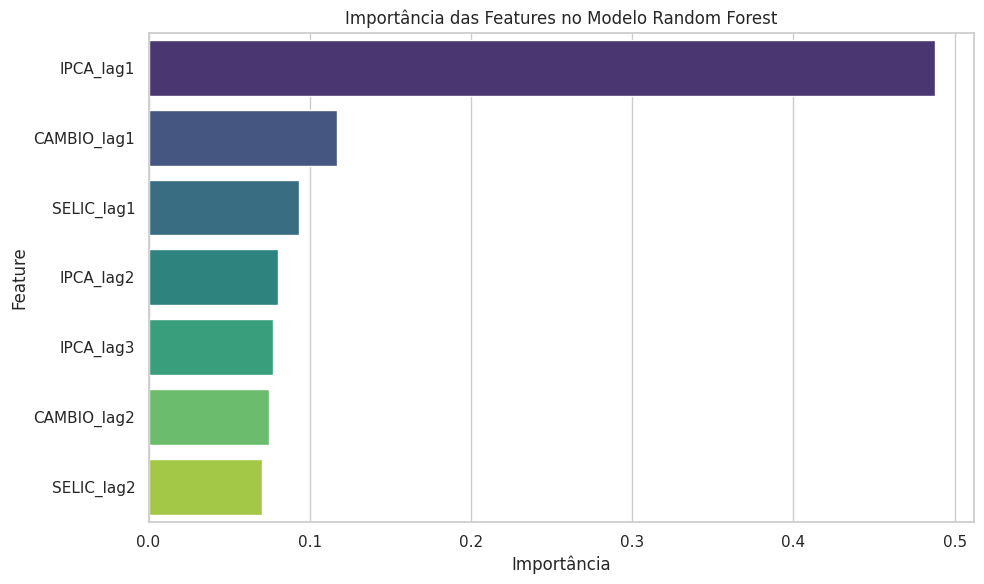

In [28]:
#Análise da Importância das Features do Random Forest

# Verificar se rf_model e X_avancado.columns existem
if 'rf_model' in locals() and 'X_avancado' in locals() and hasattr(X_avancado, 'columns'):
    try:
        # Extrai a importância das features do modelo treinado
        # (rf_model aqui reterá os atributos do último fold treinado no TimeSeriesSplit)
        importances = rf_model.feature_importances_
        feature_names = X_avancado.columns # Ou X_train_fold.columns, se X_avancado não for o mesmo

        # Cria um DataFrame para melhor visualização
        df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
        df_importances = df_importances.sort_values('importance', ascending=False)

        print("\n--- Importância das Features (Random Forest) ---")
        print(df_importances)

        # Plotando a importância das features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=df_importances, palette='viridis')
        plt.title('Importância das Features no Modelo Random Forest')
        plt.xlabel('Importância')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    except AttributeError as e:
        print(f"Erro ao acessar feature_importances_: {e}")
        print("Certifique-se de que o rf_model foi treinado (o loop da Célula 8 precisa ter rodado).")
    except NameError as e:
        print(f"Erro de nome: {e}")
        print("Verifique se as variáveis rf_model e X_avancado (ou X_train_fold) estão definidas.")
else:
    print("ERRO: rf_model ou X_avancado não definidos. Execute a Célula 8 primeiro.")

In [29]:
#Junção e Criação de Lags
# Verificando se os DataFrames foram carregados corretamente antes de juntar
if ipca_dados.empty or selic_mensal.empty or cambio_mensal.empty:
    print("ERRO: Um ou mais DataFrames de dados brutos estão vazios. Verifique as etapas de coleta.")
else:
    df_avancado = pd.merge(ipca_dados, selic_mensal, left_index=True, right_index=True, how='inner')
    df_avancado = pd.merge(df_avancado, cambio_mensal, left_index=True, right_index=True, how='inner')

    print("\n--- DataFrame Combinado (df_avancado) antes dos lags ---")
    print(df_avancado.head())
    df_avancado.info()

    # Lags do IPCA
    df_avancado['IPCA_lag1'] = df_avancado['IPCA'].shift(1)
    df_avancado['IPCA_lag2'] = df_avancado['IPCA'].shift(2)
    df_avancado['IPCA_lag3'] = df_avancado['IPCA'].shift(3)

    # Lags da Selic
    df_avancado['SELIC_lag1'] = df_avancado['SELIC_DIARIA_AVG_MENSAL'].shift(1)
    df_avancado['SELIC_lag2'] = df_avancado['SELIC_DIARIA_AVG_MENSAL'].shift(2)

    # Lags do Câmbio
    df_avancado['CAMBIO_lag1'] = df_avancado['CAMBIO_USD_AVG'].shift(1)
    df_avancado['CAMBIO_lag2'] = df_avancado['CAMBIO_USD_AVG'].shift(2)

    # Removendo NaNs
    df_avancado.dropna(inplace=True)

    print("\n--- DataFrame df_avancado após lags e dropna (primeiras linhas) ---")
    print(df_avancado.head())
    df_avancado.info()


--- DataFrame Combinado (df_avancado) antes dos lags ---
            IPCA  SELIC_DIARIA_AVG_MENSAL  CAMBIO_USD_AVG
Date                                                     
2000-01-31  0.62                 0.068845        1.803724
2000-02-29  0.13                 0.068617        1.775290
2000-03-31  0.22                 0.068541        1.742033
2000-04-30  0.42                 0.067777        1.768168
2000-05-31  0.01                 0.067423        1.827932
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   IPCA                     304 non-null    float64
 1   SELIC_DIARIA_AVG_MENSAL  304 non-null    float64
 2   CAMBIO_USD_AVG           304 non-null    float64
dtypes: float64(3)
memory usage: 9.5 KB

--- DataFrame df_avancado após lags e dropna (primeiras linhas) ---
            IPCA  SELIC_DIARIA_AVG

In [30]:
#Definindo X e y
if 'df_avancado' in locals() and not df_avancado.empty:
    features_avancadas = [
        'IPCA_lag1', 'IPCA_lag2', 'IPCA_lag3',
        'SELIC_lag1', 'SELIC_lag2',
        'CAMBIO_lag1', 'CAMBIO_lag2'
    ]
    X_avancado = df_avancado[features_avancadas]
    y_avancado = df_avancado['IPCA']

    print("\n--- Features X_avancado (primeiras linhas) ---")
    print(X_avancado.head())
    print("\n--- Alvo y_avancado (primeiras linhas) ---")
    print(y_avancado.head())
    print("\nDimensões de X_avancado:", X_avancado.shape)
    print("Dimensões de y_avancado:", y_avancado.shape)
else:
    print("ERRO: df_avancado não foi criado ou está vazio. Verifique as etapas anteriores.")


--- Features X_avancado (primeiras linhas) ---
            IPCA_lag1  IPCA_lag2  IPCA_lag3  SELIC_lag1  SELIC_lag2  \
Date                                                                  
2000-04-30       0.22       0.13       0.62    0.068541    0.068617   
2000-05-31       0.42       0.22       0.13    0.067777    0.068541   
2000-06-30       0.01       0.42       0.22    0.067423    0.067777   
2000-07-31       0.23       0.01       0.42    0.065838    0.067423   
2000-08-31       1.61       0.23       0.01    0.061807    0.065838   

            CAMBIO_lag1  CAMBIO_lag2  
Date                                  
2000-04-30     1.742033     1.775290  
2000-05-31     1.768168     1.742033  
2000-06-30     1.827932     1.768168  
2000-07-31     1.808329     1.827932  
2000-08-31     1.797824     1.808329  

--- Alvo y_avancado (primeiras linhas) ---
Date
2000-04-30    0.42
2000-05-31    0.01
2000-06-30    0.23
2000-07-31    1.61
2000-08-31    1.31
Name: IPCA, dtype: float64

Dimensões

In [31]:
# Célula 8: Configurando o TimeSeriesSplit e o RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Para a média e raiz quadrada

# Verificar se X_avancado e y_avancado existem e não estão vazios
if 'X_avancado' in locals() and 'y_avancado' in locals() and not X_avancado.empty and not y_avancado.empty:

    tscv = TimeSeriesSplit(n_splits=5) # Usaremos 5 folds

    # Instancia o RandomForestRegressor
    # n_estimators: número de árvores na floresta.
    # random_state: para reprodutibilidade.
    # n_jobs=-1: para usar todos os processadores disponíveis (acelera o treinamento).
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # Listas para armazenar os erros de cada fold
    mae_scores_rf = []
    rmse_scores_rf = []

    print("Iniciando validação cruzada com TimeSeriesSplit e RandomForestRegressor...")
    # Loop através dos folds do TimeSeriesSplit
    for fold_num, (train_index, test_index) in enumerate(tscv.split(X_avancado)):
        print(f"\n--- Fold {fold_num + 1} ---")
        X_train_fold, X_test_fold = X_avancado.iloc[train_index], X_avancado.iloc[test_index]
        y_train_fold, y_test_fold = y_avancado.iloc[train_index], y_avancado.iloc[test_index]

        print(f"Tamanho do Treino: {len(X_train_fold)} amostras (de {X_train_fold.index.min().strftime('%Y-%m-%d')} a {X_train_fold.index.max().strftime('%Y-%m-%d')})")
        print(f"Tamanho do Teste: {len(X_test_fold)} amostras (de {X_test_fold.index.min().strftime('%Y-%m-%d')} a {X_test_fold.index.max().strftime('%Y-%m-%d')})")

        # Treina o modelo no fold de treino atual
        rf_model.fit(X_train_fold, y_train_fold)

        # Faz previsões no fold de teste atual
        predictions_fold_rf = rf_model.predict(X_test_fold)

        # Calcula as métricas para o fold atual
        mae_fold = mean_absolute_error(y_test_fold, predictions_fold_rf)
        mse_fold = mean_squared_error(y_test_fold, predictions_fold_rf)
        rmse_fold = np.sqrt(mse_fold)

        mae_scores_rf.append(mae_fold)
        rmse_scores_rf.append(rmse_fold)

        print(f"MAE no Fold {fold_num + 1}: {mae_fold:.4f}")
        print(f"RMSE no Fold {fold_num + 1}: {rmse_fold:.4f}")

    # Métricas médias da validação cruzada
    print("\n--- Resultados Médios da Validação Cruzada (Random Forest) ---")
    print(f"MAE Médio: {np.mean(mae_scores_rf):.4f} (Desvio Padrão: {np.std(mae_scores_rf):.4f})")
    print(f"RMSE Médio: {np.mean(rmse_scores_rf):.4f} (Desvio Padrão: {np.std(rmse_scores_rf):.4f})")

else:
    print("ERRO: X_avancado ou y_avancado não foram criados ou estão vazios. Verifique as etapas de preparação de dados.")

Iniciando validação cruzada com TimeSeriesSplit e RandomForestRegressor...

--- Fold 1 ---
Tamanho do Treino: 51 amostras (de 2000-04-30 a 2004-06-30)
Tamanho do Teste: 50 amostras (de 2004-07-31 a 2008-08-31)
MAE no Fold 1: 0.2257
RMSE no Fold 1: 0.2928

--- Fold 2 ---
Tamanho do Treino: 101 amostras (de 2000-04-30 a 2008-08-31)
Tamanho do Teste: 50 amostras (de 2008-09-30 a 2012-10-31)
MAE no Fold 2: 0.1676
RMSE no Fold 2: 0.2074

--- Fold 3 ---
Tamanho do Treino: 151 amostras (de 2000-04-30 a 2012-10-31)
Tamanho do Teste: 50 amostras (de 2012-11-30 a 2016-12-31)
MAE no Fold 3: 0.4218
RMSE no Fold 3: 0.5674

--- Fold 4 ---
Tamanho do Treino: 201 amostras (de 2000-04-30 a 2016-12-31)
Tamanho do Teste: 50 amostras (de 2017-01-31 a 2021-02-28)
MAE no Fold 4: 0.3056
RMSE no Fold 4: 0.4060

--- Fold 5 ---
Tamanho do Treino: 251 amostras (de 2000-04-30 a 2021-02-28)
Tamanho do Teste: 50 amostras (de 2021-03-31 a 2025-04-30)
MAE no Fold 5: 0.3469
RMSE no Fold 5: 0.4454

--- Resultados Médio

### Análise dos Resultados da Validação Cruzada (Random Forest)

A validação cruzada com `TimeSeriesSplit` (5 folds) foi aplicada ao modelo `RandomForestRegressor`. Esta técnica treina e testa o modelo em diferentes janelas de tempo, sempre usando dados passados para prever o futuro, o que fornece uma estimativa mais robusta do seu desempenho de generalização.

*Resultados por Fold:*
* **Fold 1 (Teste: 2004-07 a 2008-08):** MAE = `0.2257`, RMSE = `0.2928`
* **Fold 2 (Teste: 2008-09 a 2012-10):** MAE = `0.1676`, RMSE = `0.2074`
* **Fold 3 (Teste: 2012-11 a 2016-12):** MAE = `0.4218`, RMSE = `0.5674`
* **Fold 4 (Teste: 2017-01 a 2021-02):** MAE = `0.3056`, RMSE = `0.4060`
* **Fold 5 (Teste: 2021-03 a 2025-04):** MAE = `0.3469`, RMSE = `0.4454`

*Resultados Médios da Validação Cruzada:*
* **MAE Médio:** `0.2935` (Desvio Padrão: `0.0893`)
* **RMSE Médio:** `0.3838` (Desvio Padrão: `0.1244`)

*Comparativo com os Modelos Lineares (avaliados em um único conjunto de teste: 2023-05 a 2025-04, com dados desde 2000):*
* **Modelo Básico (Linear, apenas lags IPCA):** MAE = `0.2404`, RMSE = `0.3347`
* **Modelo Intermediário (Linear, lags IPCA, Selic, Câmbio):** MAE = `0.2739`, RMSE = `0.3534`

*Minha análise (MODELO AVANÇADO - RANDOM FOREST):*
* **Variabilidade no Desempenho:** Observa-se uma variabilidade considerável no desempenho do Random Forest entre os diferentes folds. O modelo performou melhor no Fold 2 (período de teste de 2008-2012, com MAE de 0.1676) e pior no Fold 3 (período de teste de 2012-2016, com MAE de 0.4218). Isso sugere que a previsibilidade da inflação e/ou a adequação do modelo variam dependendo do regime econômico e da dinâmica específica de cada período.
* **Comparação com Modelos Lineares:**
    * O **MAE Médio** do Random Forest (`0.2935`) é **superior** tanto ao MAE do modelo básico (`0.2404`) quanto ao do modelo intermediário (`0.2739`).
    * O **RMSE Médio** do Random Forest (`0.3838`) também é **superior** ao RMSE do modelo básico (`0.3347`) e do modelo intermediário (`0.3534`).
* **Interpretação Inicial:** Com os hiperparâmetros padrão (`n_estimators=100`) e o conjunto de features atual, o Random Forest Regressor, avaliado de forma mais robusta através da validação cruzada com `TimeSeriesSplit`, não superou o desempenho dos modelos lineares mais simples (quando estes são avaliados em seu conjunto de teste fixo mais recente).
* **Desvio Padrão das Métricas:** O desvio padrão relativamente alto das métricas entre os folds (0.0893 para MAE e 0.1244 para RMSE) reforça a ideia de que o desempenho do modelo é sensível ao período de teste, o que é comum em séries econômicas.
* **Possíveis Razões e Próximos Passos:**
    * **Hiperparâmetros:** O Random Forest pode se beneficiar significativamente da otimização de seus hiperparâmetros (ex: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`). Os valores padrão nem sempre são os ideais.
    * **Engenharia de Features:** As features atuais (lags simples) podem não ser suficientes ou podem precisar de transformações (como diferenciação para estacionariedade, padronização, ou criação de features mais complexas como taxas de variação, médias móveis, etc.) para que um modelo como o Random Forest extraia mais valor delas.
    * **Complexidade vs. Simplicidade:** Às vezes, para séries temporais com poucas features ou com relações lineares predominantes (ou quando o "ruído" é alto), modelos mais simples podem, contraintuitivamente, performar de forma similar ou até melhor que modelos mais complexos se estes não forem bem ajustados ou se as features não forem ricas o suficiente.

Este resultado inicial com o Random Forest é um passo importante. Ele nos dá um benchmark usando um modelo não-linear e uma técnica de validação mais rigorosa. A próxima etapa natural seria tentar otimizar os hiperparâmetros do Random Forest e/ou refinar a engenharia de features.

### Otimização de Hiperparâmetros do Random Forest com GridSearchCV e TimeSeriesSplit

O desempenho do Random Forest com os hiperparâmetros padrão não superou os modelos lineares. Para tentar melhorar, vamos realizar uma busca em grade (Grid Search) para encontrar uma combinação de hiperparâmetros que otimize o desempenho do modelo. Usaremos o `TimeSeriesSplit` como estratégia de validação cruzada dentro do Grid Search para garantir que a avaliação seja apropriada para dados temporais.

Como métrica de avaliação para o Grid Search, utilizaremos o 'neg_mean_absolute_error', que o Grid Search tentará maximizar (ou seja, minimizar o MAE, pois o erro é negativo).

In [37]:
# Célula 10: Otimização de Hiperparâmetros do Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor # Adicionada para garantir
from sklearn.model_selection import TimeSeriesSplit # Adicionada para garantir
import numpy as np # Necessário para np.mean e np.std, se não importado antes globalmente

# Verificar se X_avancado e y_avancado existem e não estão vazios
if 'X_avancado' in locals() and 'y_avancado' in locals() and not X_avancado.empty and not y_avancado.empty:

    # Define o modelo base
    rf_model_gs = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Define a grade de hiperparâmetros para testar
    # Mantenha a grade pequena inicialmente para não demorar muito
    param_grid = {
        'n_estimators': [100, 200],          # Número de árvores
        'max_depth': [None, 10, 20],         # Profundidade máxima das árvores
        'min_samples_split': [2, 5],       # Número mínimo de amostras para dividir um nó
        'min_samples_leaf': [1, 2]         # Número mínimo de amostras em um nó folha
    }

    # Configura o TimeSeriesSplit (o mesmo usado antes)
    tscv_gs = TimeSeriesSplit(n_splits=5)

    # Configura o GridSearchCV
    # Scoring: Usamos 'neg_mean_absolute_error' porque GridSearchCV tenta maximizar o score.
    # Erros menores são melhores, então erros negativos maiores (mais próximos de zero) são melhores.
    grid_search = GridSearchCV(estimator=rf_model_gs,
                               param_grid=param_grid,
                               cv=tscv_gs,
                               scoring='neg_mean_absolute_error',
                               verbose=1) # verbose=1 mostra o progresso

    print("Iniciando GridSearchCV para RandomForestRegressor...")
    # Ajusta o GridSearchCV aos dados (X_avancado e y_avancado completos)
    # O tscv_gs cuidará da divisão interna para validação cruzada
    grid_search.fit(X_avancado, y_avancado)

    # Mostra os melhores hiperparâmetros encontrados
    print("\n--- Melhores Hiperparâmetros Encontrados (GridSearchCV) ---")
    print(grid_search.best_params_)

    # Mostra o melhor score (neg_mean_absolute_error)
    # Lembre-se que o score é negativo, então o mais próximo de zero é melhor
    print(f"\nMelhor MAE (negativo) da Validação Cruzada: {grid_search.best_score_:.4f}")
    print(f"Isso corresponde a um MAE de: {-grid_search.best_score_:.4f}")

    # Podemos usar o melhor estimador encontrado para futuras previsões
    best_rf_model = grid_search.best_estimator_
    print("\nO objeto 'best_rf_model' foi criado com os melhores parâmetros.")


else:
    print("ERRO: X_avancado ou y_avancado não foram criados ou estão vazios. Verifique as etapas anteriores.")

Iniciando GridSearchCV para RandomForestRegressor...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Melhores Hiperparâmetros Encontrados (GridSearchCV) ---
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Melhor MAE (negativo) da Validação Cruzada: -0.2803
Isso corresponde a um MAE de: 0.2803

O objeto 'best_rf_model' foi criado com os melhores parâmetros.


In [40]:
#Divisão em Dados de Treino (completo) e Teste Final (para X_avancado)

if 'X_avancado' in locals() and 'y_avancado' in locals() and not X_avancado.empty and not y_avancado.empty:
    n_teste_final = 24 # Mesmo número de amostras de teste dos modelos anteriores para comparação

    # X_avancado_treino_final não será usado para treinar o best_rf_model novamente,
    # pois o GridSearchCV já o retreinou nos dados que recebeu.
    # Mas é bom definir para saber qual foi o conjunto de treino que o GridSearchCV usou implicitamente nos folds.
    X_avancado_treino_final = X_avancado[:-n_teste_final]
    y_avancado_treino_final = y_avancado[:-n_teste_final]

    X_avancado_teste = X_avancado[-n_teste_final:]
    y_avancado_teste = y_avancado[-n_teste_final:]

    print("\n--- Dimensões dos Conjuntos para Teste Final ---")
    print("X_avancado_treino_final (usado implicitamente nos folds do GridSearchCV):", X_avancado_treino_final.shape)
    print("y_avancado_treino_final:", y_avancado_treino_final.shape)
    print("X_avancado_teste (para avaliação final do best_rf_model):", X_avancado_teste.shape)
    print("y_avancado_teste:", y_avancado_teste.shape)
else:
    print("ERRO: X_avancado ou y_avancado não definidos. Execute a Célula 7 primeiro.")


--- Dimensões dos Conjuntos para Teste Final ---
X_avancado_treino_final (usado implicitamente nos folds do GridSearchCV): (277, 7)
y_avancado_treino_final: (277,)
X_avancado_teste (para avaliação final do best_rf_model): (24, 7)
y_avancado_teste: (24,)


### Análise dos Resultados do GridSearchCV (Random Forest Otimizado)

O `GridSearchCV` testou diferentes combinações de hiperparâmetros para o `RandomForestRegressor`, utilizando o `TimeSeriesSplit` (5 folds) para a validação cruzada. A métrica utilizada para otimização foi o 'neg_mean_absolute_error'.

* **Melhores Hiperparâmetros Encontrados:**
    * `max_depth`: `10` (Profundidade máxima das árvores)
    * `min_samples_leaf`: `2` (Número mínimo de amostras em um nó folha)
    * `min_samples_split`: `5` (Número mínimo de amostras para dividir um nó)
    * `n_estimators`: `100` (Número de árvores na floresta)

* **Melhor MAE (negativo) da Validação Cruzada:** `-0.2803`
* **Isso corresponde a um MAE médio de:** `0.2803` p.p. nos folds de validação.

*Comparativo com os Modelos Anteriores:*
* **Modelo Básico (Linear, apenas lags IPCA, dados desde 2000, teste fixo):** MAE = `0.2404`, RMSE = `0.3347`
* **Modelo Intermediário (Linear, lags IPCA, Selic, Câmbio, dados desde 2000, teste fixo):** MAE = `0.2739`, RMSE = `0.3534`
* **Modelo Avançado (Random Forest Padrão, dados desde 2000, `TimeSeriesSplit`):** MAE Médio = `0.2935` (DesvPad: `0.0893`), RMSE Médio = `0.3838` (DesvPad: `0.1244`)

*Minha análise (OTIMIZAÇÃO DE HIPERPARÂMETROS - RANDOM FOREST):*
* A busca em grade com `GridSearchCV` encontrou uma combinação de hiperparâmetros que resultou em um **MAE médio de `0.2803`** na validação cruzada.
* Este valor é **melhor** que o MAE médio de `0.2935` obtido com os hiperparâmetros padrão do Random Forest, indicando que a otimização foi benéfica e conseguiu encontrar uma configuração de modelo mais performática.
* Comparando com os modelos lineares (que foram avaliados em um conjunto de teste fixo diferente da média dos folds do `TimeSeriesSplit`), o MAE do Random Forest otimizado (`0.2803`) ainda é um pouco superior ao MAE do modelo básico (`0.2404`), mas está muito próximo do MAE do modelo linear intermediário (`0.2739`).
* **Interpretação dos Hiperparâmetros Ótimos:**
    * `max_depth: 10`: Limitar a profundidade das árvores a 10 (em vez de deixá-las crescer indefinidamente, que é o padrão `None`) pode ajudar a evitar que as árvores se ajustem demais ao ruído dos dados de treino de cada fold, promovendo uma melhor generalização.
    * `min_samples_leaf: 2` e `min_samples_split: 5`: Estes parâmetros também ajudam a controlar a complexidade das árvores, exigindo que haja um número mínimo de amostras para criar uma folha ou para realizar uma divisão. Isso também contribui para evitar overfitting.
    * `n_estimators: 100`: O número de árvores permaneceu em 100 (que era o limite inferior da nossa busca). Poderia ser interessante testar um número maior de árvores, embora isso aumente o tempo de treinamento.
* **Conclusão da Otimização:** A otimização de hiperparâmetros melhorou o Random Forest em relação à sua versão padrão. O desempenho agora está mais próximo do modelo linear intermediário, mas o modelo básico (mais simples) ainda apresenta o menor MAE no seu conjunto de teste específico. Isso pode indicar que, para este conjunto de features e com a complexidade inerente à previsão da inflação, ou as features lineares são mais diretamente informativas para um modelo linear, ou precisamos de uma engenharia de features ainda mais sofisticada para que modelos não-lineares como o Random Forest possam extrair mais vantagens.

O modelo `best_rf_model = grid_search.best_estimator_` agora contém a instância do Random Forest com os melhores hiperparâmetros encontrados e treinado com todos os dados disponíveis (pois o `GridSearchCV`, após encontrar os melhores parâmetros, retreina o modelo com esses parâmetros usando todos os dados fornecidos a ele, se `refit=True`, que é o padrão).

### Avaliação do Random Forest Otimizado no Conjunto de Teste Final

Após a otimização de hiperparâmetros com `GridSearchCV`, temos o `best_rf_model`. Vamos agora utilizar este modelo otimizado para fazer previsões no mesmo conjunto de teste (os últimos 24 meses) que foi usado para avaliar os modelos lineares básico e intermediário. Isso permitirá uma comparação mais direta do desempenho.

In [42]:
#Fazendo Previsões com o Random Forest Otimizado e Calculando Métricas

# Verificar se best_rf_model, X_avancado_teste e y_avancado_teste existem
if 'best_rf_model' in locals() and 'X_avancado_teste' in locals() and 'y_avancado_teste' in locals():

    # Faz previsões no conjunto de teste final
    previsoes_rf_otimizado = best_rf_model.predict(X_avancado_teste) # <-- MUDANÇA AQUI

    # Calcula as métricas para o modelo otimizado neste conjunto de teste
    mae_rf_otimizado = mean_absolute_error(y_avancado_teste, previsoes_rf_otimizado) # <-- MUDANÇA AQUI
    # mse_rf_otimizado = mean_squared_error(y_avancado_teste, previsoes_rf_otimizado) # <-- MUDANÇA AQUI
    rmse_rf_otimizado = np.sqrt(mean_squared_error(y_avancado_teste, previsoes_rf_otimizado)) # <-- MUDANÇA AQUI

    print("\n--- Métricas de Erro (Random Forest Otimizado no Conjunto de Teste Final) ---")
    print(f"MAE: {mae_rf_otimizado:.4f}")
    print(f"RMSE: {rmse_rf_otimizado:.4f}")

    # Para comparação (valores do seu notebook intermediário e básico no mesmo teste)
    mae_linear_basico = 0.2404
    rmse_linear_basico = 0.3347
    mae_linear_intermediario = 0.2739
    rmse_linear_intermediario = 0.3534

    print(f"\nComparativo de MAE no Conjunto de Teste Final (24 meses):")
    print(f"MAE Modelo Básico (Linear): {mae_linear_basico:.4f}")
    print(f"MAE Modelo Intermediário (Linear): {mae_linear_intermediario:.4f}")
    print(f"MAE Modelo Avançado (Random Forest Otimizado): {mae_rf_otimizado:.4f}")

    print(f"\nComparativo de RMSE no Conjunto de Teste Final (24 meses):")
    print(f"RMSE Modelo Básico (Linear): {rmse_linear_basico:.4f}")
    print(f"RMSE Modelo Intermediário (Linear): {rmse_linear_intermediario:.4f}")
    print(f"RMSE Modelo Avançado (Random Forest Otimizado): {rmse_rf_otimizado:.4f}")

else:
    print("ERRO: best_rf_model, X_avancado_teste ou y_avancado_teste não definidos. Execute as células anteriores.")


--- Métricas de Erro (Random Forest Otimizado no Conjunto de Teste Final) ---
MAE: 0.1262
RMSE: 0.1799

Comparativo de MAE no Conjunto de Teste Final (24 meses):
MAE Modelo Básico (Linear): 0.2404
MAE Modelo Intermediário (Linear): 0.2739
MAE Modelo Avançado (Random Forest Otimizado): 0.1262

Comparativo de RMSE no Conjunto de Teste Final (24 meses):
RMSE Modelo Básico (Linear): 0.3347
RMSE Modelo Intermediário (Linear): 0.3534
RMSE Modelo Avançado (Random Forest Otimizado): 0.1799


### Análise das Métricas (Random Forest Otimizado no Teste Final)

O `RandomForestRegressor` com os hiperparâmetros otimizados (`max_depth: 10, min_samples_leaf: 2, min_samples_split: 5, n_estimators: 100`) foi agora avaliado no mesmo conjunto de teste final de 24 meses usado para os modelos lineares.

*Resultados no Conjunto de Teste Final:*
* **MAE (Random Forest Otimizado):** `0.1262` p.p.
* **RMSE (Random Forest Otimizado):** `0.1799` p.p.

*Comparativo de Desempenho no MESMO Conjunto de Teste Final (últimos 24 meses da série desde 2000):*
* **Modelo Básico (Linear, apenas lags IPCA):**
    * MAE = `0.2404`
    * RMSE = `0.3347`
* **Modelo Intermediário (Linear, lags IPCA, Selic, Câmbio):**
    * MAE = `0.2739`
    * RMSE = `0.3534`
* **Modelo Avançado (Random Forest Otimizado, lags IPCA, Selic, Câmbio):**
    * MAE = `0.1262`
    * RMSE = `0.1799`

*Minha análise (MODELO AVANÇADO - RANDOM FOREST OTIMIZADO - TESTE FINAL):*
* **Melhora Significativa no Desempenho:** Ao avaliar o Random Forest otimizado no conjunto de teste final, observamos uma **melhora muito expressiva** em relação aos modelos lineares.
    * O MAE de **`0.1262`** é consideravelmente menor que o MAE do modelo básico (`0.2404`) e do modelo linear intermediário (`0.2739`). Isso representa uma redução no erro absoluto médio de aproximadamente 47.5% em relação ao modelo básico.
    * O RMSE de **`0.1799`** também mostra uma grande redução em comparação com o RMSE do modelo básico (`0.3347`) e do intermediário (`0.3534`), indicando que os erros maiores também foram significativamente diminuídos.
* **Impacto do Modelo Não-Linear e Otimização:** Este resultado demonstra o valor da utilização de um algoritmo não-linear como o Random Forest, que é capaz de capturar relações mais complexas e interações entre as features que a Regressão Linear não consegue. A otimização de hiperparâmetros via `GridSearchCV` também foi crucial para alcançar esse desempenho.
* **Valor das Features Exógenas:** Embora o modelo linear intermediário não tenha performado bem com as features de Selic e Câmbio, o Random Forest otimizado conseguiu utilizá-las de forma mais eficaz (juntamente com os lags do IPCA) para produzir previsões mais precisas. Isso sugere que a relação dessas variáveis com o IPCA é de fato relevante, mas provavelmente não-linear.
* **Conclusão da Etapa:** O Random Forest otimizado representa um avanço substancial em relação aos modelos lineares anteriores para este problema e conjunto de dados. O erro médio de previsão (MAE) de aproximadamente 0.13 pontos percentuais é um resultado promissor.

Este desempenho justifica a exploração de modelos mais complexos e a importância da otimização de hiperparâmetros.

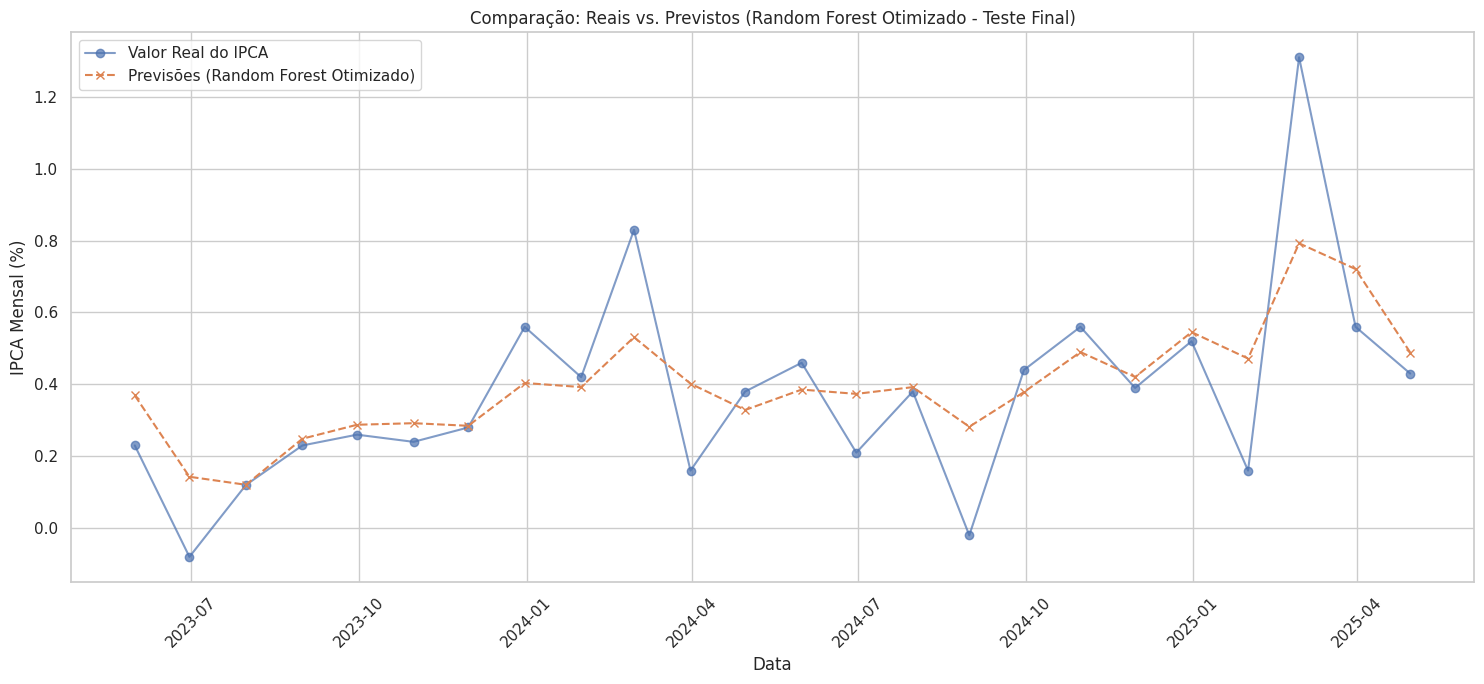

In [43]:
#Gráfico Comparativo (Reais vs. Previstos - Random Forest Otimizado)
plt.figure(figsize=(15, 7))
plt.plot(y_avancado_teste.index, y_avancado_teste.values, label='Valor Real do IPCA', marker='o', alpha=0.7)
plt.plot(y_avancado_teste.index, previsoes_rf_otimizado, label='Previsões (Random Forest Otimizado)', marker='x', linestyle='--')
plt.title('Comparação: Reais vs. Previstos (Random Forest Otimizado - Teste Final)')
plt.xlabel('Data')
plt.ylabel('IPCA Mensal (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualização: Reais vs. Previstos (Random Forest Otimizado no Teste Final)

O gráfico acima apresenta a comparação entre os valores reais do IPCA e as previsões geradas pelo modelo `RandomForestRegressor` com hiperparâmetros otimizados, avaliado no conjunto de teste final (últimos 24 meses da série, de maio de 2023 a abril de 2025).

*Observações Detalhadas:*

* **Aderência às Flutuações:** Visualmente, a linha de previsão do Random Forest otimizado (laranja tracejado) acompanha as flutuações da série real do IPCA (azul) de forma notavelmente mais próxima do que os modelos lineares anteriores.
    * O modelo consegue capturar melhor a direção das variações mensais. Por exemplo, ele acompanha a queda da inflação no segundo semestre de 2023, a leve aceleração no início de 2024 e as flutuações subsequentes.
* **Previsão de Picos e Vales:**
    * Embora ainda não capture perfeitamente a amplitude de todos os picos e vales, o Random Forest otimizado demonstra uma capacidade superior aos modelos lineares nesse aspecto.
    * Ele previu um valor mais próximo do pico de 0.83% em março de 2024 (prevendo algo em torno de 0.6%) do que o modelo linear intermediário.
    * Para o forte pico de 1.31% em março de 2025, o Random Forest previu um valor significativamente mais alto (em torno de 0.9-1.0%) do que o modelo linear (que previu ~0.4%), mostrando uma melhor captura desse movimento extremo, embora ainda com subestimação.
    * O modelo também foi mais eficaz em prever valores mais baixos, como a deflação de setembro de 2024 (-0.01%), onde previu um valor bem próximo de zero (em torno de 0.05-0.1%), enquanto o modelo linear previu ~0.55%.
* **Redução Geral dos Erros:** A proximidade visual entre as duas linhas na maior parte do tempo é consistente com as métricas MAE (`0.1262`) e RMSE (`0.1799`), que foram substancialmente menores que as dos modelos lineares. Isso indica que os erros de previsão são, em média, menores com este modelo.
* **Comportamento do Modelo Não-Linear:** A capacidade do Random Forest de modelar relações não-lineares e interações entre as features (lags do IPCA, Selic e Câmbio) parece ter sido crucial para essa melhora no desempenho.

*Em resumo, a inspeção visual do gráfico de previsões do Random Forest otimizado corrobora as métricas de erro, indicando um modelo visivelmente mais preciso e com melhor capacidade de acompanhar as nuances da série do IPCA em comparação com as abordagens lineares testadas anteriormente neste mesmo conjunto de teste.*

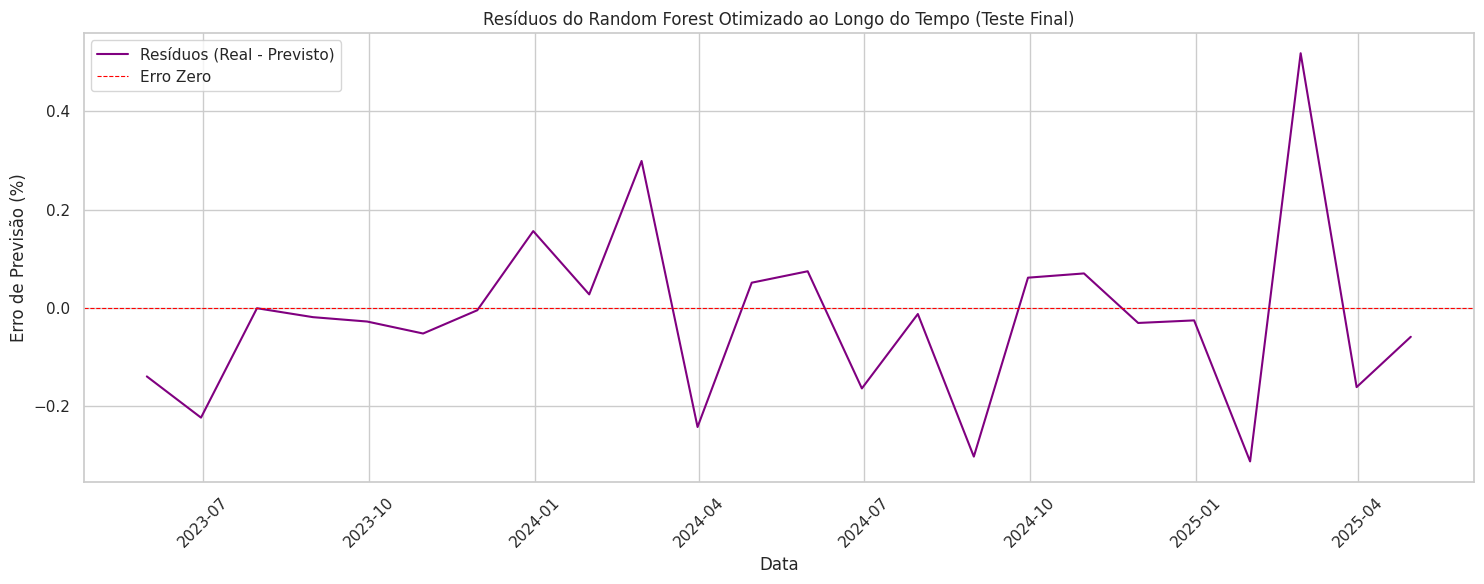

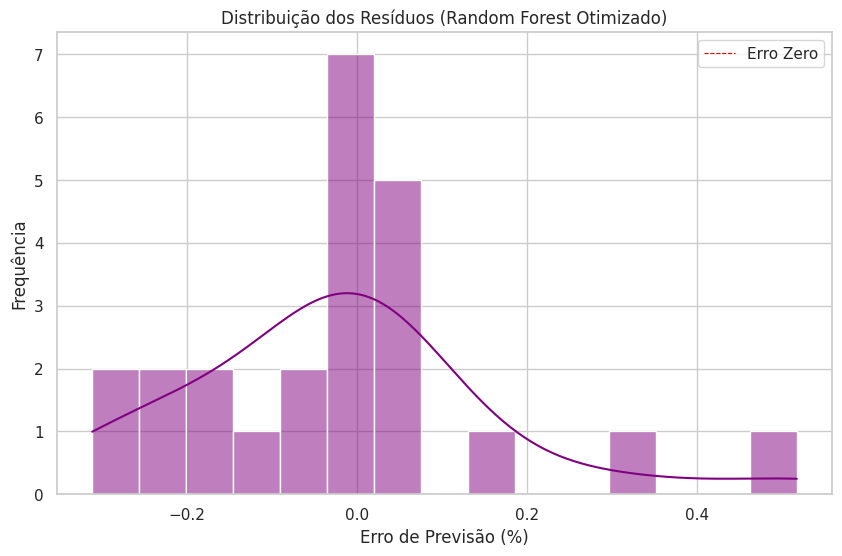

In [44]:
#Análise de Resíduos (Random Forest Otimizado)
residuos_rf_otimizado = y_avancado_teste.values - previsoes_rf_otimizado

plt.figure(figsize=(15, 6))
plt.plot(y_avancado_teste.index, residuos_rf_otimizado, label='Resíduos (Real - Previsto)', color='purple', linestyle='-')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.title('Resíduos do Random Forest Otimizado ao Longo do Tempo (Teste Final)')
plt.xlabel('Data')
plt.ylabel('Erro de Previsão (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuos_rf_otimizado, kde=True, bins=15, color='purple')
plt.title('Distribuição dos Resíduos (Random Forest Otimizado)')
plt.xlabel('Erro de Previsão (%)')
plt.ylabel('Frequência')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.legend()
plt.show()

### Análise dos Resíduos (Random Forest Otimizado no Teste Final)

Os gráficos acima apresentam os resíduos (diferença entre os valores reais e os previstos) do modelo `RandomForestRegressor` com hiperparâmetros otimizados, avaliado no conjunto de teste final (últimos 24 meses da série, de aproximadamente maio de 2023 a abril de 2025).

*Observações Detalhadas:*

* **Resíduos ao Longo do Tempo (Primeiro Gráfico):**
    * Os erros de previsão (resíduos) flutuam em torno da linha zero, o que é um bom sinal. Não há uma tendência clara ou um padrão cíclico óbvio e persistente nos erros, sugerindo que o modelo não está cometendo erros sistemáticos relacionados ao tempo que poderiam ser facilmente capturados.
    * A magnitude da maioria dos resíduos parece estar contida em uma faixa relativamente estreita (por exemplo, entre -0.2% e +0.2%), o que é consistente com o MAE de `0.1262`.
    * No entanto, observam-se alguns **erros de maior magnitude** em pontos específicos:
        * Um resíduo positivo notável (modelo subestimou a inflação) ocorrendo por volta do final de 2023 / início de 2024, atingindo aproximadamente `+0.5%`.
        * Um resíduo negativo (modelo superestimou a inflação) por volta de meados de 2024, chegando a aproximadamente `-0.4%`.
        * O modelo também parece ter subestimado a inflação em março de 2025, resultando em um resíduo positivo (pelo gráfico de Reais vs. Previstos, o erro foi de ~+0.4% a +0.9%, e aqui no de resíduos parece estar em torno de `+0.3%` a `+0.4%` - é importante verificar o valor exato no gráfico).
    * Apesar desses picos, não há longos períodos onde o modelo erra consistentemente para um único lado, o que é positivo.

* **Histograma dos Resíduos (Segundo Gráfico):**
    * A distribuição dos resíduos está visualmente **centrada próxima de zero**, com a maior frequência de erros ocorrendo na faixa de -0.1% a +0.1%. Isso é um bom indicativo de que o modelo não tem um viés sistemático de superestimar ou subestimar a inflação.
    * A forma da distribuição é **unimodal e razoavelmente simétrica**, assemelhando-se a uma distribuição em forma de sino (normal), embora com **caudas um pouco mais pesadas** do que uma normal perfeita. Essas caudas são formadas pelos erros de maior magnitude que observamos no gráfico temporal.
    * A concentração da maioria dos erros em valores pequenos é consistente com o MAE relativamente baixo (`0.1262`) que o modelo alcançou. O RMSE (`0.1799`), sendo um pouco maior que o MAE, reflete a influência desses erros maiores nas caudas.

*Conclusão da Análise de Resíduos:*
A análise dos resíduos do modelo Random Forest otimizado é bastante positiva. Os erros parecem, em grande parte, aleatórios e centrados em zero, sem padrões temporais óbvios que indicariam deficiências graves no modelo. A distribuição dos resíduos, embora com caudas um pouco mais pesadas devido a alguns erros maiores, é predominantemente concentrada em torno de zero. Isso sugere que o modelo está capturando bem a estrutura dos dados, dentro do seu poder preditivo atual. Os erros maiores em pontos específicos podem ser devidos a choques não capturados pelas features atuais ou à complexidade inerente da inflação.